In [1]:
print(__doc__)

import numpy as np
import csv
import xlrd
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

Automatically created module for IPython interactive environment


# Data Pre-Processing

### xls file --> csv file

In [3]:
def xl2csv(xlname, csvname):
    your_csv_file = open(csvname, 'wb')
    wr = csv.writer(your_csv_file)

    wb = xlrd.open_workbook(xlname)#'globalterrorismdb_0617dist.xlsx')
    sh = wb.sheet_by_index(0)

    for rownum in xrange(sh.nrows):
        row = []
        for item in sh.row_values(rownum):
            if type(item) == unicode:
                item = item.encode('utf-8')
            row.append(item)
        wr.writerow(row)

    your_csv_file.close()

#데이터의 수가 많아 엑셀 로딩시간이 오래 걸려, 파일들을 csv파일로 변환하였다.

In [ ]:
def csv_div_save(orgn_fname, columns):
    fname = columns[0]
    for colname in columns[1:]:
        fname = fname + '_' + colname
    your_csv_file = open(fname+'.csv', 'wb')
    wr = csv.writer(your_csv_file)

    f = open(orgn_fname, 'r')
    rdr = csv.reader(f)
    
    for j, line in enumerate(rdr):
        if j == 0:
            col_list = line        
            i_list = []
            for i, content in enumerate(line):
                if col_list[i] in columns:
                    i_list.append(i)
            print i_list
        row = []
        for ii in i_list:

            row.append(line[ii])
        wr.writerow(row)  
    
    your_csv_file.close()
    f.close()
#데이터 처리를 쉽게 하기 위해 clustering이나 RNN에 쓰일 데이터들을 따로 저장하였다.

# Clustering

## 1. K-means clustering & Visualization

In [46]:
from geoplotlib.colors import create_set_cmap
import pyglet
from sklearn.cluster import KMeans
import geoplotlib
from geoplotlib.layers import BaseLayer
from geoplotlib.core import BatchPainter
from geoplotlib.utils import BoundingBox
import numpy as np
import csv

### Read csv file
- read location(latitude, longitude) csv file 

In [47]:
def recsv(orgn_fname):
    f = open(orgn_fname, 'r')
    rdr = csv.reader(f)

    X = []
    for j, line in enumerate(rdr):
        if j > 0:
            X.append([float(i) for i in line])
    f.close()
    return np.array(X)

### Make KMeans Layer
- k-means cluster using 'Sckit-learn' and visualize using 'Geoplotlib'

In [48]:
class KMeansLayer(BaseLayer):

    def __init__(self, fname):
        self.fname = fname
        self.k = 2


    def invalidate(self, proj):
        self.painter = BatchPainter()
        arr = recsv(self.fname)
        lat = arr[:,0]
        lon = arr[:,1]
        
        x, y = proj.lonlat_to_screen(lon, lat)

        k_means = KMeans(n_clusters=self.k)
        k_means.fit(np.vstack([x,y]).T)
        labels = k_means.labels_

        self.cmap = create_set_cmap(set(labels), 'hsv')
        for l in set(labels):
            self.painter.set_color(self.cmap[l])
            self.painter.convexhull(x[labels == l], y[labels == l])
            self.painter.points(x[labels == l], y[labels == l], 2)
    
            
    def draw(self, proj, mouse_x, mouse_y, ui_manager):
        ui_manager.info('Use left and right to increase/decrease the number of clusters. k = %d' % self.k)
        self.painter.batch_draw()


    def on_key_release(self, key, modifiers):
        if key == pyglet.window.key.LEFT:
            self.k = max(2,self.k - 1)
            return True
        elif key == pyglet.window.key.RIGHT:
            self.k = self.k + 1
            return True
        return False

In [49]:
geoplotlib.add_layer(KMeansLayer('new_latitude_longitude.csv'))
geoplotlib.set_smoothing(True)
geoplotlib.set_bbox(geoplotlib.utils.BoundingBox.DK)
geoplotlib.show()

### K - means는 가장 보편적인 클러스터링 방법이지만 모든 데이터를 포함해서 구역을 나누기 때문에 밀집지역으로 부터 동떨어진 데이터들도 포함하게 된다. 그래서 이러한 노이즈 데이터들을 제외시킬 수 있는 밀도 중심의 클러스터링, DBSCAN을 이용해 클러스터링을 진행하였다.

## 2. DBSCAN (Density Based Spatial Clustering of Applications with Noise )

### - Eliminate noise data

In [15]:
print(__doc__)

import numpy as np
import csv

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

Automatically created module for IPython interactive environment


### Read csv file
- read location(latitude, longitude) csv file 

In [19]:
orgn_fname = 'new_latitude_longitude.csv'

f = open(orgn_fname, 'r')
rdr = csv.reader(f)

X = []
for j, line in enumerate(rdr):
    if j > 0:
        X.append([float(i) for i in line])
f.close()
X = np.array(X)

### Compute DBSCAN
- compute DBSCAN using 'Sckit-learn'

In [20]:
db = DBSCAN(eps=1.5, min_samples=40).fit(X)

### Save the results of DBSCAN
- save the labels (result of clustering) in original GTD data
- add 1 column named 'cluster'

In [21]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)

core_samples_mask[db.core_sample_indices_] = True

labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 82


In [25]:
"""
your_csv_file = open('clustered_gtd.csv', 'w')
wr = csv.writer(your_csv_file)

f = open('new_gtd.csv', 'r')
rdr = csv.reader(f)

for j, line in enumerate(rdr):
    if j == 0:
        line.append('cluster')
        wr.writerow(line)
    else:
        line.append(labels[j - 1])
        wr.writerow(line)
your_csv_file.close()
f.close()
"""

<class 'list'>


### Plot results of DBSCAN
- plot the results of clustering using labels and locations

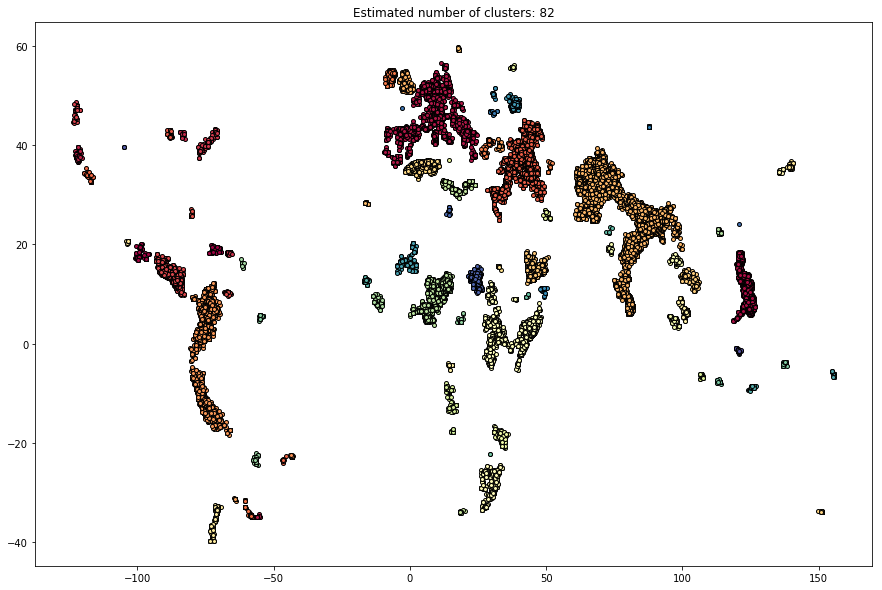

In [26]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
plt.figure(figsize = (15, 10))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=4)


    xy = X[class_member_mask & ~core_samples_mask]
    #plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### DBSCAN 을 통해 eps : 1.5, min_sample : 40으로 클러스터링을 진행한 결과, 총 82개의 cluster가 생성되었으며, 이 label들을 데이터에 새로운 column으로 추가하여 분석을 진행하였다. 파라미터 설정 기준은 밀접한 위치의 데이터들을 최대한 알맞게 나누어져있느냐에 대한 것이었으며, 밀집지역과 동떨어진 데이터, 즉 노이즈 제외여부에 따른 것이었다. 
### clustering 결과, 인도, 서아시아 부근과 유럽, 남아메리카 부근에 큰 cluster들이 위치한 것을 알 수 있었으며, 동북아시아에는 위 기준의 밀집지역이 나타나지 않는 것을 알 수 있다.

# Data Analysis


In [27]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import scipy
import peakutils

%matplotlib inline

# Data input

In [28]:
cluster=pd.read_csv('rm_clustered_gtd.csv')
df=pd.DataFrame(cluster)

In [29]:
df=df[['success','iyear','imonth','country','suicide','attacktype1','targtype1','targsubtype1','natlty1','individual','nperps','nperpcap','weaptype1','weapsubtype1','cluster']
]

## Attack type에 따른 테러 발생 횟수의 분포

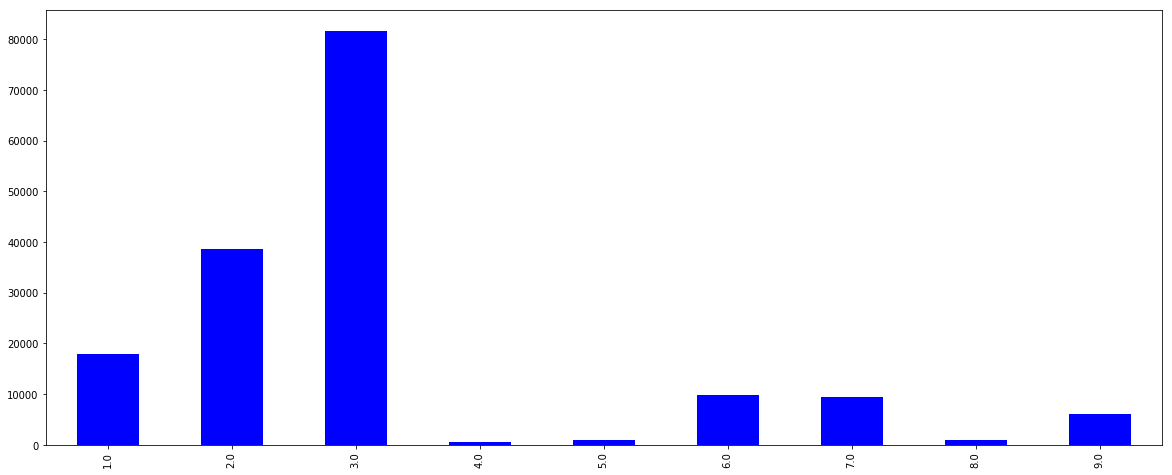

In [30]:
attack_df=df[['success','attacktype1']]
count_attack_df=attack_df.groupby('attacktype1').count()
count_attack_df=count_attack_df.reset_index()
suc_attack_df=attack_df.groupby('attacktype1').agg(sum)
sucrate_attack_df=suc_attack_df.reset_index()
for i in range(0,9):
    sucrate_attack_df['success'].iloc[i]=100*(suc_attack_df['success'].iloc[i]/count_attack_df['success'].iloc[i])

ackm=[]
ackn=[]
for i in range(0,9):
    ackm.append(count_attack_df['attacktype1'].iloc[i])
    ackn.append(count_attack_df['success'].iloc[i])
data = pd.Series(ackn, ackm)

data.plot(kind='bar', color='b', alpha=1, figsize=(20,8))

### 전체 사건에 대해서 attack type에 따른 테러 발생횟수의 분포를 나타낸 것이다. 여기서 3(bomb, explosion)을 이용한 테러가 두드러지게 많이 나타났고 그 다음으로 2(armed assault) 방식의 테러가 많이 일어남을 알 수 있다.

## Attack type에 따른 total distribution에 영향을 크게 미치는 cluster 분석

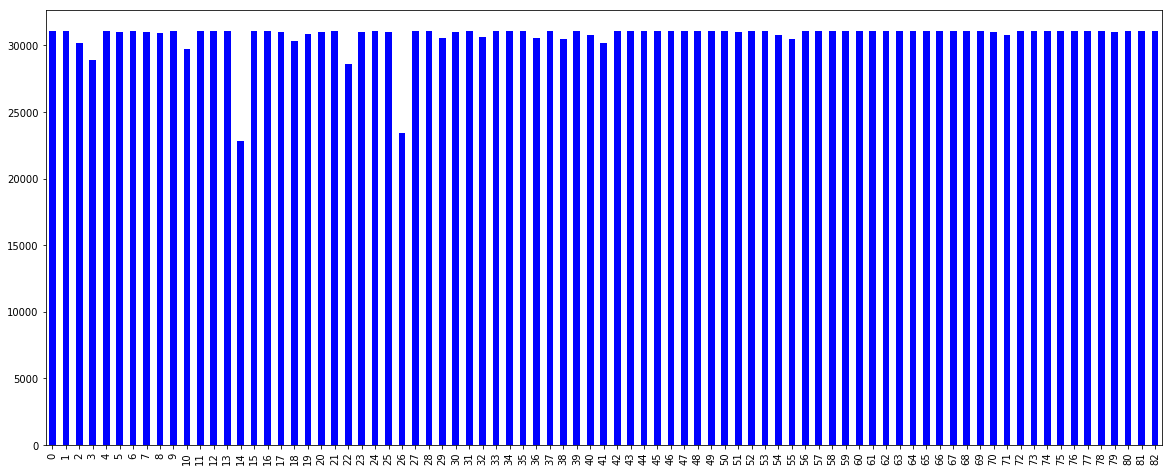

In [31]:
Attack_df=df[['success','attacktype1','cluster']]
count_Attack_df=Attack_df.groupby(['cluster','attacktype1']).count()
count_Attack_df=count_Attack_df.reset_index()

t=[]
n=[]
for k in range(0,83):
    Ackm=[]
    Ackn=[]
    for i in range(0,619):
        if count_Attack_df['cluster'].iloc[i]==k:
            Ackm.append(count_Attack_df['attacktype1'].iloc[i])
            Ackn.append(count_Attack_df['success'].iloc[i])
    
    if len(ackn)==len(Ackn):
        s=0
        for j in range(0,len(ackn)):
            s=s+(ackn[j]-Ackn[j])**2
        s=(1/3)*np.sqrt(s)
    else:
        x=[]
        for j in range(0,len(ackn)):
            x.append(-1)
        for y2 in range(0,len(ackm)):
            for y1 in range(0,len(Ackm)):
                if Ackm[y1]==y2+1:
                    x[y2]=Ackn[y1]
        for y in range(0,len(ackm)):
            if x[y]==-1:
                x[y]=0
        s=0
        for j in range(0,len(ackn)):
            s=s+(ackn[j]-x[j])**2
        s=(1/3)*np.sqrt(s)
                        
    t.append(s)
    n.append(k)
        
data=pd.Series(t,n)
data.plot(kind='bar', color='b', alpha=1, figsize=(20,8))



### 위 코드에서는 전체적인 attack type에 대한 테러 발생 횟수의 distrubution이 위와 같은 형태를 가지는데 가장 많이 기여한 cluster가 무엇인지 확인할 수 있는 방법을 생각해보았다. 
### 그 전에 두 distribution f,g가 서로 얼마나 다른지를 측정할 수 있는 식( d(f,g)라고 하자 )을 잡게 되었고 그 식에 대해서 각 cluster의 index i에 대하여 d((total attacktype distribution), (i-cluster attacktype distribution)를 측정한 그래프를 그린 것이다. 
### 그 결과 위처럼 14와 26에서 minimal peak가 나온다는 것을 확인할 수 있었고 이런 성질이 cluster의 어떤 성질과 관련 있는지를 보기 위해서 다른 cluster들에 비해 cluster 14,26이 다른 cluster들에 비해 두드러진 특징을 보는 것이 중요하다.

# Cluster에 따른 테러 발생 횟수의 분포

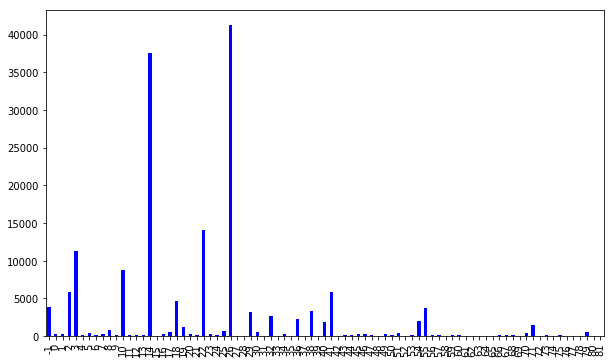

In [32]:
clus_df=df[['cluster','success']]
count_clus_df=clus_df.groupby('cluster').count()
count_clus_df=count_clus_df.reset_index()
clusm=[]
clusn=[]
for i in range(0,83):
    clusm.append(count_clus_df['success'].iloc[i])
    clusn.append(count_clus_df['cluster'].iloc[i])
data=pd.Series(clusm,clusn)
data.plot(kind='bar', color='b', alpha=1,figsize=(10,6))

### 각 cluster들에 대하여 테러 발생률을 보면 cluster 14, 26에서 많이 나타나는 것을 알 수 있다.
### 위치로 봤을 때 14는 이집트 근처 지역이고 26은 중동(아프가니스탄, 이라크 등) 지역이다. 
### 그리고 위에서 (total attacktype distribution)과의 차이에서 minimum peak가 나타나는 곳임을 알 수 있다.
### 따라서 테러가 일어난 횟수가 많을 수록 total distribution에 가깝다는 것을 알 수 있다.

## Target type에 따른 테러 발생 횟수의 분포

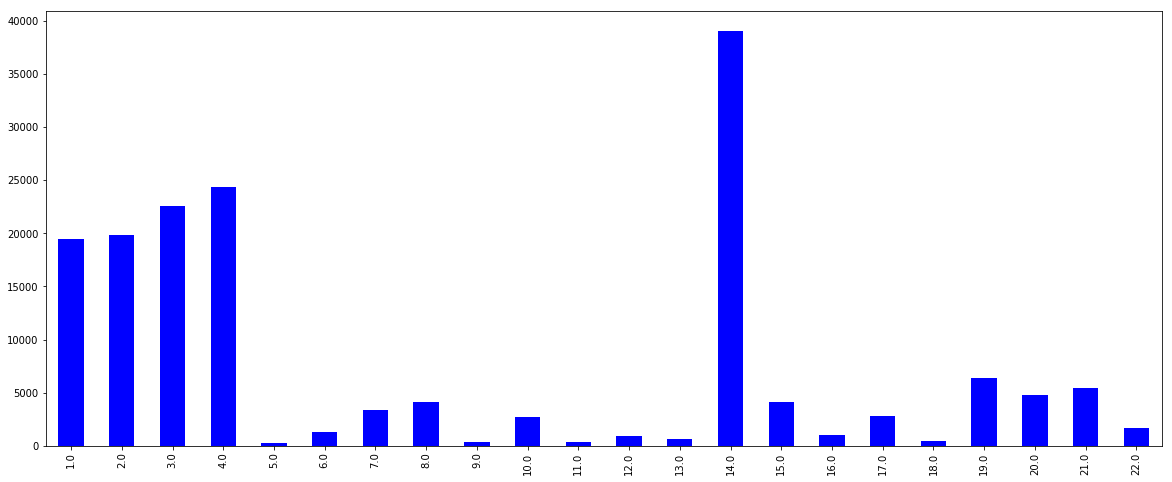

In [33]:
target_df=df[['success','targtype1']]
count_target_df=target_df.groupby('targtype1').count()
count_target_df=count_target_df.reset_index()
suc_target_df=target_df.groupby('targtype1').agg(sum)
sucrate_target_df=suc_target_df.reset_index()
for i in range(0,22):
    sucrate_target_df['success'].iloc[i]=100*(suc_target_df['success'].iloc[i]/count_target_df['success'].iloc[i])
sucrate_target_df

tagm=[]
tagn=[]
for i in range(0,22):
    tagm.append(count_target_df['targtype1'].iloc[i])
    tagn.append(count_target_df['success'].iloc[i])
data = pd.Series(tagn, tagm)

data.plot(kind='bar', color='b', alpha=1, figsize=(20,8))

### target type에 따른 테러 발생 횟수에 대한 distribution이다. 
### 14(private propery & citizen, 일반적인 시민이나 사유 재산)을 대상으로 테러가 가장 많이 일어났고
### 4(military), 3(police), 2(goverment), 1(business) 순서로 많이 일어났다.

## Target type에 따른 total distribution에 영향을 크게 미치는 cluster 분석

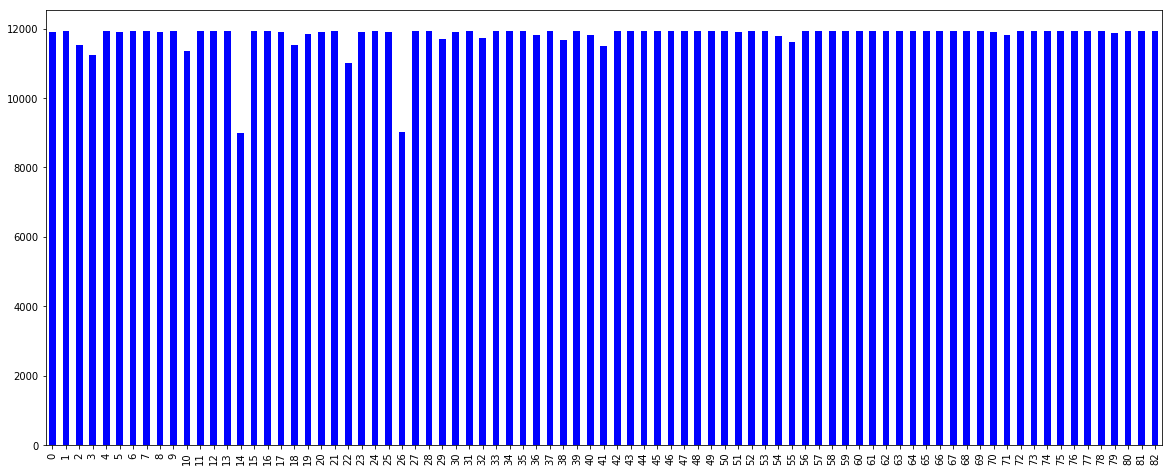

In [34]:
t_c_df=df[['targtype1','cluster','success']]
count_t_c_df=t_c_df.groupby(['cluster','targtype1']).count()
count_t_c_df=count_t_c_df.reset_index()

t=[]
n=[]
for k in range(0,83):
    Tagm=[]
    Tagn=[]
    for i in range(0,1207):
        if count_t_c_df['cluster'].iloc[i]==k:
            Tagm.append(count_t_c_df['targtype1'].iloc[i])
            Tagn.append(count_t_c_df['success'].iloc[i])
    
    if len(tagn)==len(Tagn):
        s=0
        for j in range(0,len(tagn)):
            s=s+(tagn[j]-Tagn[j])**2
        s=(1/5)*np.sqrt(s)
    else:
        x=[]
        for j in range(0,len(tagn)):
            x.append(-1)
        for y2 in range(0,len(tagm)):
            for y1 in range(0,len(Tagm)):
                if Tagm[y1]==y2+1:
                    x[y2]=Tagn[y1]
        for y in range(0,len(tagm)):
            if x[y]==-1:
                x[y]=0
        s=0
        for j in range(0,len(tagn)):
            s=s+(tagn[j]-x[j])**2
        s=(1/5)*np.sqrt(s)
                        
    t.append(s)
    n.append(k)
       
data=pd.Series(t,n)
data.plot(kind='bar', color='b', alpha=1, figsize=(20,8))

### 마찬가지로 각 cluster마다 테러가 일어난 횟수가 클수록 각 cluster의 taget type에 따른 테러 횟수의 distribution과 total target type distribution이 가깝다는 것을 알 수 있다.

# Nationality에 따른 테러 발생 횟수의 분포

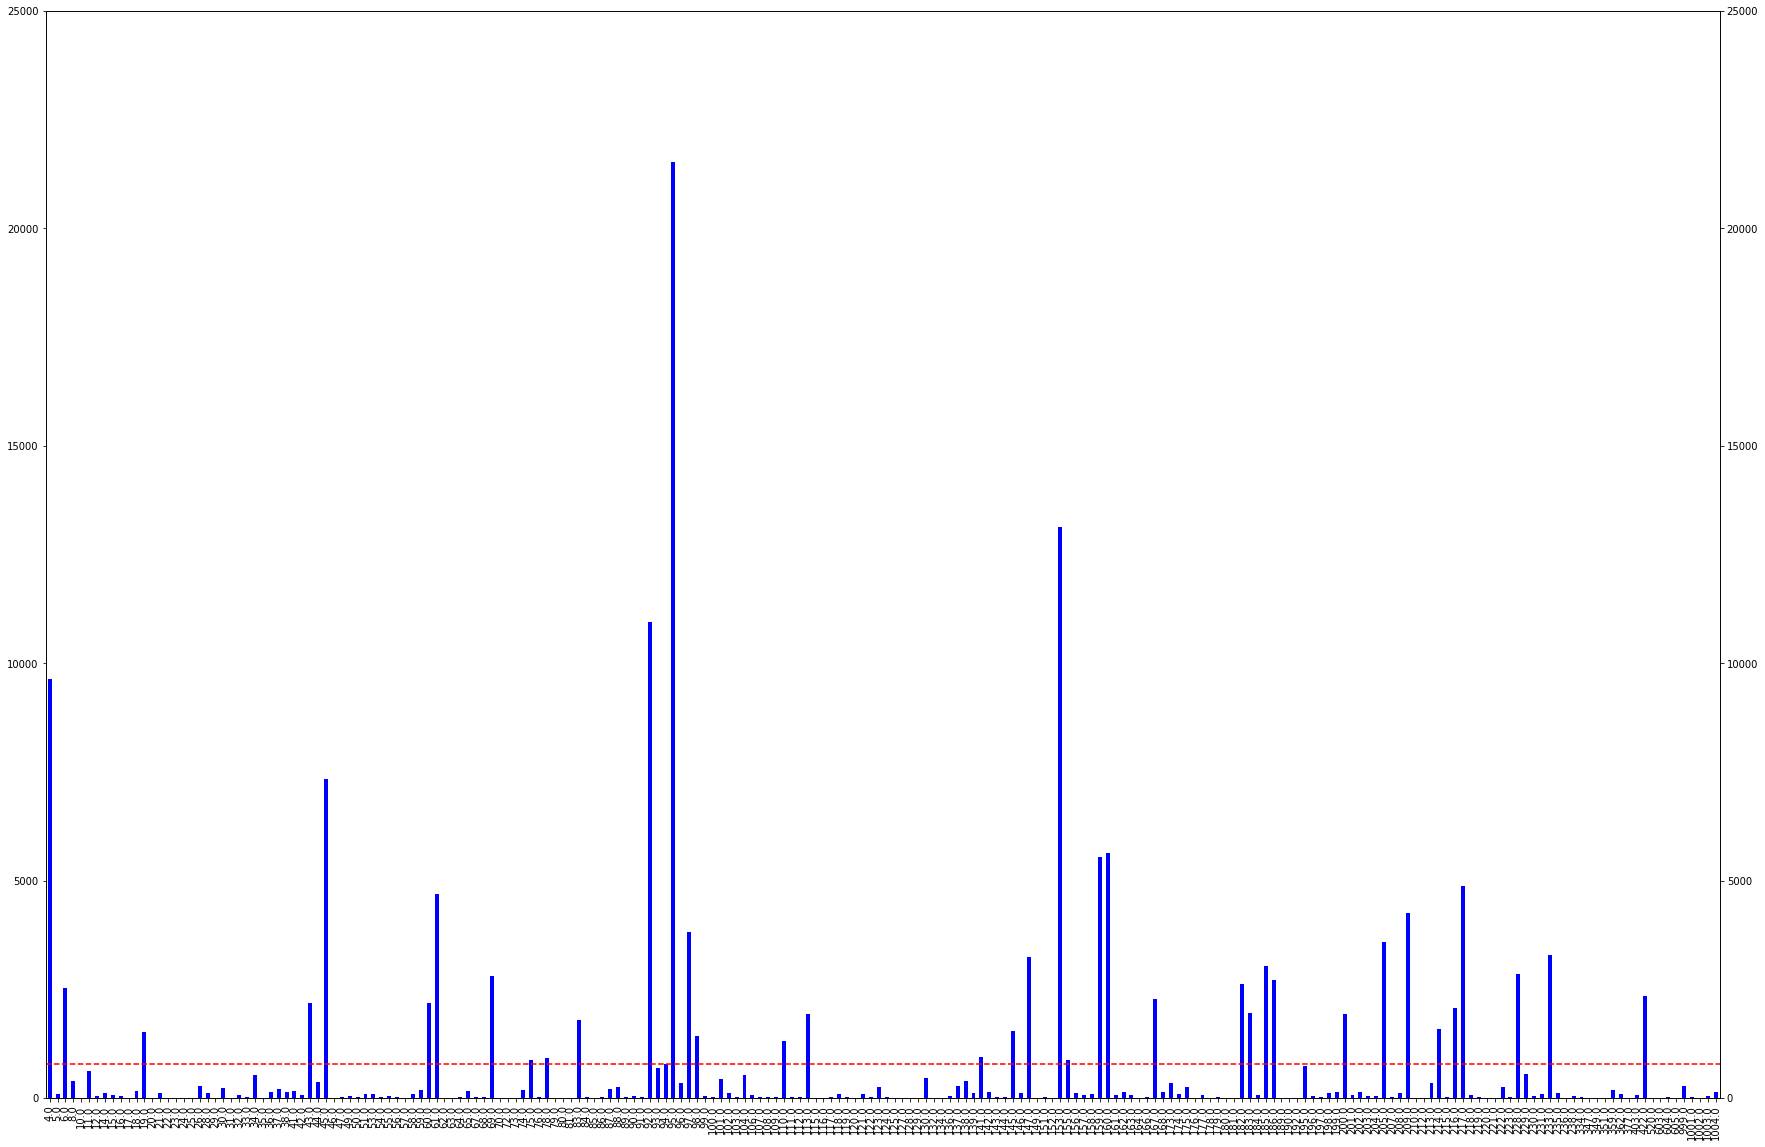

In [35]:
nat_df=df[['success','natlty1']]
count_nat_df=nat_df.groupby('natlty1').count()
count_nat_df=count_nat_df.reset_index()
suc_nat_df=nat_df.groupby('natlty1').agg(sum)
sucrate_nat_df=suc_nat_df.reset_index()
for i in range(0,212):
    sucrate_nat_df['success'].iloc[i]=100*(suc_nat_df['success'].iloc[i]/count_nat_df['success'].iloc[i])

natm=[]
natn=[]
for i in range(0,212):
    natm.append(count_nat_df['natlty1'].iloc[i])
    natn.append(count_nat_df['success'].iloc[i])
y=count_nat_df['success'].mean()
data = pd.Series(natn, natm)

ax = data.plot(kind='bar', color='b',alpha=1,figsize=(30,20))
ax = data.plot(kind='bar', color='b',alpha=1)
ax.set_ylim(0, 25000)
ax2 = ax.twinx()
ax2.set_ylim(0, 25000)
ax2.axhline(y,color='r',linestyle='--')

### 테러를 당한 기관이 소속된 국가에 따른 테러횟수의 분포를 나타낸 것이다. 빨간색 점선은 전체 테러횟수에 대한 산술평균이고 maximal peak들에 해당되는 여러 국가들을 살펴보았을 때 가장 높은 테러횟수가 이라크(95)에서 일어났고 그 다음으로 파키스탄(153), 인도(92), 아프가니스탄(4)에서 높은 횟수를 보였다.